In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def gaussian(mean=None,var=None):
    def f(X):
        return np.linalg.det(2*np.pi*var)**(0.5) * np.exp(-0.5*np.dot((X - mean).T,np.dot(np.linalg.inv(var),X - mean)))
    return f

def gaussian1d(mean=None,var=None):
    def f(X):
        return (2*np.pi*var)**(0.5) * np.exp(-0.5*(x-mean)**2/var)
    return f


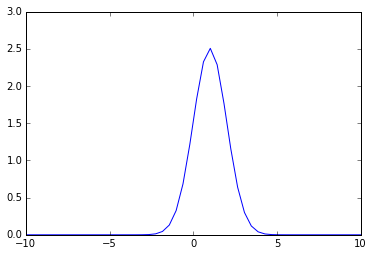

In [12]:
X = np.linspace(-10,10)
gauss = gaussian1d(mean=1.0, var=1.0)
Y = np.array([gauss(x) for x in X])
plt.plot(X,Y)

In [13]:
def ext_kalman_filter_factory(state_transfer=lambda control_input, posterior_mean:None,
                              state_transfer_jacobian= lambda control_input, posterior_mean:None,
                              state_transfer_noise=None,
                              measurement_predictor=lambda predicted_mean:None,
                              measurement_predictor_jacobian=lambda predicted_mean:None,
                              measurement_noise=None):
    def ext_kalman_filter(prior_mean, prior_variance, control_input, sensor_results):
        mean_after_control = state_transfer(control_input, prior_mean)
        variance_after_control = np.dot(state_transfer_jacobian(control_input,prior_mean),
                                        np.dot(prior_variance,
                                               state_transfer_jacobian(control_input, prior_mean).T)) + state_transfer_noise
        kalman_gain = np.dot(variance_after_control,
                             np.dot(measurement_predictor_jacobian(mean_after_control).T,
                                    np.linalg.inv(np.dot(measurement_predictor_jacobian(mean_after_control),
                                                         np.dot(variance_after_control,
                                                                measurement_predictor_jacobian(mean_after_control).T)) + measurement_noise)))
        posterior_mean = mean_after_control + np.dot(kalman_gain, sensor_results - measurement_predictor(mean_after_control))
        posterior_variance = variance_after_control - np.dot(kalman_gain,
                                                             np.dot(measurement_predictor_jacobian(posterior_mean),
                                                                    variance_after_control))
        return posterior_mean, posterior_variance
    return ext_kalman_filter

In [14]:
def steering_robot_state_transfer(drive_dist, pose):
    d = drive_dist[0,0]
    x, y, theta = pose[0,0], pose[1,0], pose[2,0]
    return np.array([[x + d*np.cos(theta)],
                     [y + d*np.sin(theta)],
                     [theta]])

def steering_robot_state_jacobian(drive_dist, posterior_mean):
    d = drive_dist[0,0]
    x, y, theta = posterior_mean[0,0], posterior_mean[1,0], posterior_mean[2,0]
    return np.array([[1.0, 0.0, -d*np.sin(theta)],
                     [0.0, 1.0, d*np.cos(theta)],
                     [0.0, 0.0, 1.0]])

def measurement_predictor(pose):
    y = pose[1,0]
    return np.array([[y]])

def measurement_jacobian(pose):
    return np.array([[0.0, 1.0, 0.0]])

kal = ext_kalman_filter_factory(state_transfer=steering_robot_state_transfer,
                                state_transfer_jacobian=steering_robot_state_jacobian,
                                state_transfer_noise=np.zeros((3,3)),
                                measurement_predictor=measurement_predictor,
                                measurement_predictor_jacobian=measurement_jacobian,
                                measurement_noise=np.array([[0.1]]))

In [15]:
mean, var = kal(np.array([[0.0],[0.0],[0.0]]), 
                np.array([[0.01,0.0,0.0],[0.0,10,0.0],[0.0,0.0,10.0]]),
                np.array([[1.0]]),
                np.array([[6.0]]))
print mean
print var

[[ 1.        ]
 [ 5.97014925]
 [ 2.98507463]]
[[ 0.01        0.          0.        ]
 [ 0.          0.09950249  0.04975124]
 [ 0.          0.04975124  5.02487562]]


/home/chris/.anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


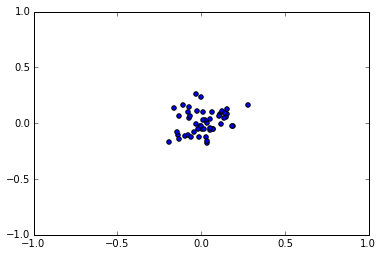

In [16]:
import numpy.random as rand

n_samples = 50
mean = np.array([0,0,0])
cov = np.array([[0.01,0.0,0],
                [0.0,0.01,0],
                [0,0,10000]])
particles = rand.multivariate_normal(mean, cov, n_samples)
plt.axis([-1,1,-1,1])
plt.scatter(particles.T[0],particles.T[1])

In [17]:
def particle_filter_factory(state_dimension,
                            prob_sample_given_control=lambda given_control,given_prior:None,
                            prob_input_given_state=lambda get_sensor, in_state:None):
    def particle_filter(prior_particles, control, sensor):
        m = len(prior_particles)
        temporary_particles = np.zeros((m, state_dimension))
        temporary_weights = np.zeros(m)
        for i in range(0,m):
            xi = prob_sample_given_control(control,
                                           prior_particles[i])
            wi = prob_input_given_state(sensor, xi)
            temporary_particles[i] = xi
            temporary_weights[i] = wi
        temporary_weights /= np.sum(temporary_weights)
        
        posterior_particles = []
        for i in range(0,m):
            j = rand.choice(m, replace=True, p=temporary_weights)           
            posterior_particles.append(temporary_particles[j])
        return np.array(posterior_particles)
    return particle_filter
        

[-1.5, 1.5, -1.5, 1.5]

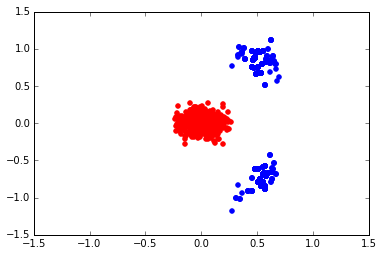

In [18]:
def move(d, given_prior):
    x, y, theta = given_prior[0], given_prior[1], given_prior[2]
    return np.array([x + d*np.cos(theta), y + d*np.sin(theta), theta])

" A perfect radius sensor "
rad_sensor_std_div = 100.0
def sample(sensor_data, state):
    x, y = state[0], state[1]
    return np.exp(-rad_sensor_std_div *(x - sensor_data)**2)
    

pf = particle_filter_factory(3,
                             prob_sample_given_control=move,
                             prob_input_given_state=sample)

n_samples=500
particles = rand.multivariate_normal(mean, cov, n_samples)
plt.scatter(particles.T[0], particles.T[1], color='red')
Xt = pf(particles, 1.0, 0.5)
plt.scatter(Xt.T[0], Xt.T[1], color='blue'); plt.axis([-1.5,1.5,-1.5,1.5])